In [1]:
import math

import matplotlib.pyplot as plt
import torch

In [124]:
class GaussianMixture:
    def __init__(self, locs: torch.Tensor, covs: torch.Tensor) -> None:
        self.dists = []
        for loc, cov in zip(locs, covs):
            dist = torch.distributions.MultivariateNormal(loc, cov)
            self.dists.append(dist)

        self.ndim = len(locs[0])
        self.nmodes = len(self.dists)
        
    def sample(self, size: int) -> torch.Tensor:
        sizes = torch.ones(self.nmodes) * (size // self.nmodes)
        
        indices = torch.arange(self.nmodes)
        if self.nmodes > 1:
            indices = indices[sizes > 0]

        x = torch.empty(0, device=sizes.device)
        for i in indices:
            dist = self.dists[i]
            size = int(sizes[i])
            x_k = dist.sample((size,))
            x = torch.cat((x, x_k), dim=0)
        return x

    def prob(self, x: torch.Tensor) -> None:
        p = torch.zeros(x.shape[0])
        for dist in self.dists:
            p += torch.exp(dist.log_prob(x))
        return p

In [131]:
ndim = 2
nmodes = 7
seed = 11
xmax = 7.0

torch.manual_seed(seed)

dist_locs = []
dist_covs = []
for _ in range(nmodes):
    loc = 5.0 * (torch.rand(size=(ndim,)) - 0.5)
    std = 1.0 * (torch.rand(size=(ndim,))) + 0.5
    cov = torch.eye(ndim) * std**2
    dist_locs.append(loc)
    dist_covs.append(cov)
    
dist = GaussianMixture(locs=dist_locs, covs=dist_covs)

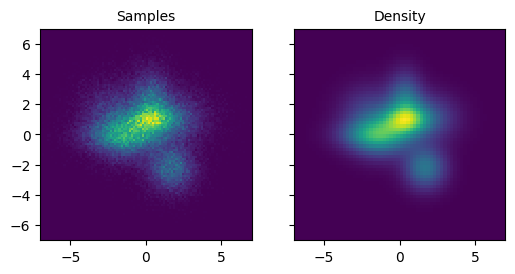

In [143]:
x = dist.sample(100_000)

grid_shape = ((64, 64))
grid_coords = [torch.linspace(-xmax, xmax, s) for s in grid_shape]
grid_points = torch.stack([c.ravel() for c in torch.meshgrid(*grid_coords, indexing="ij")], axis=-1)
grid_values = dist.prob(grid_points)
grid_values = grid_values.reshape(grid_shape)

fig, axs = plt.subplots(ncols=2, figsize=(6.0, 2.75), sharex=True, sharey=True)
axs[0].hist2d(x[:, 0], x[:, 1], bins=100, range=((-xmax, xmax), (-xmax, xmax)))
axs[1].pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
axs[0].set_title("Samples", fontsize="medium")
axs[1].set_title("Density", fontsize="medium")
plt.show()